##Importing the required modules

In [1]:
from google.colab import  drive
drive.mount('./gdrive')
%cd '/content/gdrive/MyDrive/EVA S9/EVA/S9'

Drive already mounted at ./gdrive; to attempt to forcibly remount, call drive.mount("./gdrive", force_remount=True).
/content/gdrive/MyDrive/EVA S9/EVA/S9


In [2]:
import torch
import torchvision
from torchsummary import summary
from matplotlib import pyplot as plt

In [3]:
!pip install -U albumentations

Requirement already up-to-date: albumentations in /usr/local/lib/python3.6/dist-packages (0.5.2)


In [4]:
import albumentations as A
from utils import DataProcessing
from regularizations import Regularizations
from model import *
from graphs import Graphs
from train import *
from test import *
from AlbumentationTransformations import  AlbumentationTransforms as AT
from albumentations import pytorch
from GradCam import *

## Maintaining Reproducability

In [5]:
torch.manual_seed(1)
torch.backends.cudnn.deterministic = True

##Loading the Dataset, performing image transformations and loading the DataLoader

In [6]:
data = DataProcessing('CIFAR10')


In [7]:
train_set = data.Dataset('./Data', True, True, AT([A.Cutout(),A.HorizontalFlip(), A.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)), A.pytorch.ToTensor()]))
test_set = data.Dataset('./Data', False, True, AT([A.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)), A.pytorch.ToTensor()]))


Files already downloaded and verified
Files already downloaded and verified


In [8]:
train_set.classes

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

In [9]:
train_set[0]

(tensor([[[ 0.1608,  0.1922,  0.2392,  ..., -0.6078, -0.6627, -0.5373],
          [-0.0431, -0.0667, -0.0353,  ..., -0.8588, -1.0000, -0.8745],
          [-0.1451, -0.0588, -0.0745,  ..., -0.6157, -0.8745, -0.8039],
          ...,
          [-0.5843, -0.5608,  0.2549,  ...,  0.5529,  0.5765,  0.6314],
          [-0.3490, -0.2392,  0.4431,  ...,  0.4588,  0.3569,  0.4118],
          [-0.0353,  0.1843,  0.6941,  ...,  0.4039,  0.3176,  0.3882]],
 
         [[-0.0275, -0.0196,  0.0353,  ..., -0.6235, -0.6392, -0.5137],
          [-0.3176, -0.3490, -0.3098,  ..., -0.9373, -1.0000, -0.8431],
          [-0.4275, -0.3412, -0.3412,  ..., -0.7882, -0.9451, -0.8118],
          ...,
          [-0.7333, -0.7569,  0.0431,  ...,  0.2627,  0.2000,  0.3333],
          [-0.5843, -0.5137,  0.1608,  ...,  0.1294, -0.0353,  0.0902],
          [-0.2784, -0.0745,  0.4431,  ...,  0.1137,  0.0118,  0.1294]],
 
         [[-0.1922, -0.2000, -0.1529,  ..., -0.6627, -0.6471, -0.5059],
          [-0.5529, -0.6078,

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


'truck'

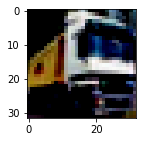

In [10]:
plt.figure(figsize=(2,2))
plt.imshow(np.transpose(train_set[1][0],(1,2,0)))
train_set.classes[train_set[1][1]]


In [11]:
train_loader = data.DataLoader(train_set, batch_size=64, shuffle=True, num_workers=4, pin_memory=True)
test_loader = data.DataLoader(test_set, batch_size=64, shuffle=True, num_workers=4, pin_memory=True)

## Taking a sneak peek at the dataset

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


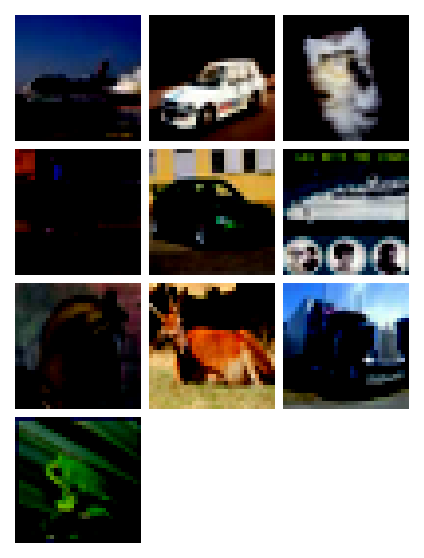

['ship', 'automobile', 'cat', 'horse', 'automobile', 'ship', 'horse', 'deer', 'truck', 'frog']


In [12]:
plt.figure(figsize=(10,10))
batch = next(iter(test_loader))
images, labels = batch
image, label = [],[]
for i in range(10):
  image.append(images[i])
  label.append(test_set.classes[labels[i]])

grid = torchvision.utils.make_grid(image, nrow=3, pad_value=1.0)
plt.imshow(np.transpose(grid, (1,2,0)))
plt.axis('off')
plt.show()
print(label)


## Viewing the parameter count used in the model

In [13]:
use_cuda = torch.cuda.is_available() # check if GPU available
device = torch.device("cuda" if use_cuda else "cpu") # use cpu if gpu is not available
model = ResNet18().to(device) 
summary(model, input_size=(3,32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
            Conv2d-3           [-1, 64, 32, 32]          36,864
       BatchNorm2d-4           [-1, 64, 32, 32]             128
            Conv2d-5           [-1, 64, 32, 32]          36,864
       BatchNorm2d-6           [-1, 64, 32, 32]             128
        BasicBlock-7           [-1, 64, 32, 32]               0
            Conv2d-8           [-1, 64, 32, 32]          36,864
       BatchNorm2d-9           [-1, 64, 32, 32]             128
           Conv2d-10           [-1, 64, 32, 32]          36,864
      BatchNorm2d-11           [-1, 64, 32, 32]             128
       BasicBlock-12           [-1, 64, 32, 32]               0
           Conv2d-13          [-1, 128, 16, 16]          73,728
      BatchNorm2d-14          [-1, 128,

##Loading the object for different regularizations

In [14]:
regularizer = Regularizations('SGD', model, 0.01, 0.9, 6, 0.1)

## Defining the main sequence of training and testing the model using the imported modules

In [15]:
def run(epochs, model, device, train_loader, regularizer, test_set, test_loader):
  train_losses, train_accuracies, test_losses, test_accuracies = [], [], [], []
  wrong_pred_data={'Images':[], 'Predicted':[], 'Actual':[]}  
  last_epoch = False
  for epoch in range(epochs):
    print(f"Epoch {epoch+1} in progress....")
    train_loss, train_accuracy = train_model(model, device, train_loader, regularizer)
    if epoch == epochs - 1:
      last_epoch = True        
    test_loss, test_accuracy = test_model(model, device, test_set, test_loader, regularizer, wrong_pred_data['Predicted'], wrong_pred_data['Actual'], wrong_pred_data['Images'], last_epoch)
    print(f"\nEpoch : {epoch+1} \n\nAverage Train Loss : {train_loss :.9f} \nTrain Accuracy : {train_accuracy : .4f}% \n\nAverage Test Loss : {test_loss :.9f} \nTest Accuracy : {test_accuracy : .4f}% \n\n")
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    test_losses.append(test_loss)
    test_accuracies.append(test_accuracy)
    regularizer.optimizer_step(step=True)
  return train_losses, train_accuracies, test_losses, test_accuracies, wrong_pred_data

## Logging the results

In [16]:
train_losses, train_accuracies, test_losses, test_accuracies, wrong_pred_data = run(25, model, device, train_loader, regularizer, test_set, test_loader)

Epoch 1 in progress....

Epoch : 1 

Average Train Loss : 0.023666945 
Train Accuracy :  45.1120% 

Average Test Loss : 0.018719480 
Test Accuracy :  58.6200% 


Epoch 2 in progress....

Epoch : 2 

Average Train Loss : 0.016494756 
Train Accuracy :  62.5180% 

Average Test Loss : 0.015716379 
Test Accuracy :  66.4300% 


Epoch 3 in progress....

Epoch : 3 

Average Train Loss : 0.013209624 
Train Accuracy :  70.1740% 

Average Test Loss : 0.011629074 
Test Accuracy :  74.2000% 


Epoch 4 in progress....

Epoch : 4 

Average Train Loss : 0.011162385 
Train Accuracy :  74.8500% 

Average Test Loss : 0.010143405 
Test Accuracy :  77.9100% 


Epoch 5 in progress....

Epoch : 5 

Average Train Loss : 0.009891481 
Train Accuracy :  77.8140% 

Average Test Loss : 0.008749809 
Test Accuracy :  80.9100% 


Epoch 6 in progress....

Epoch : 6 

Average Train Loss : 0.008875308 
Train Accuracy :  79.9900% 

Average Test Loss : 0.008897455 
Test Accuracy :  80.9500% 


Epoch 7 in progress....

Epo

## Plotting the graph for the logged results

In [17]:
graphs = Graphs('Validation Loss', 'Validation Accuracy')


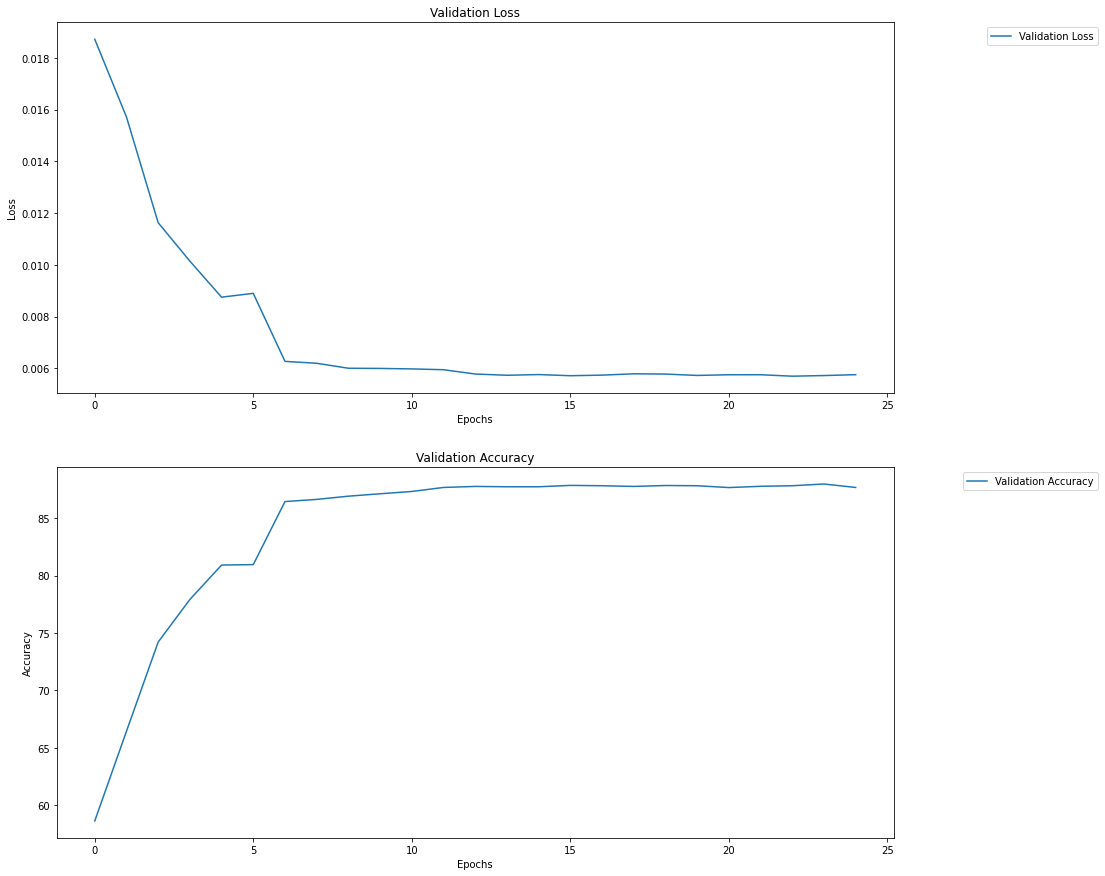

In [18]:
graphs.line_graph((15,15), test_losses, test_accuracies)


## Plotting 25 Misclassified Predictions

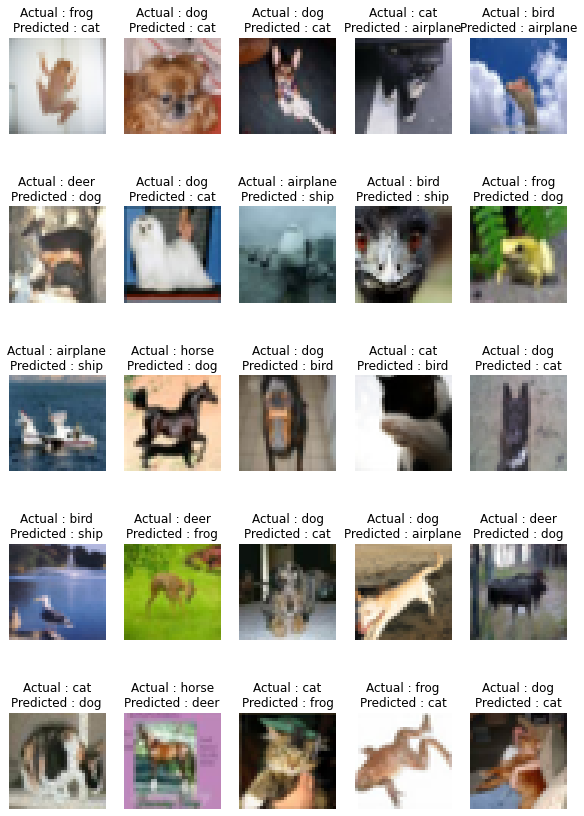

In [19]:
graphs.image_graph(5, 5, wrong_pred_data['Predicted'], wrong_pred_data['Actual'], wrong_pred_data['Images'])

In [20]:
target_layers = ["layer1","layer2","layer3","layer4"]
viz_cam = VisualizeCam(model, test_set, test_set.classes, target_layers)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

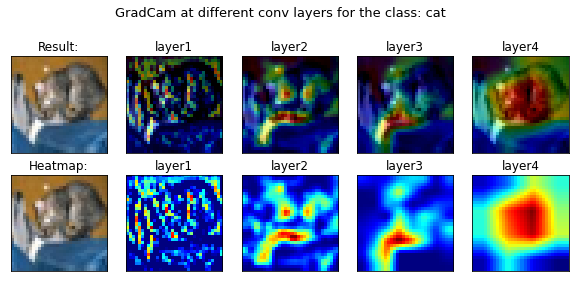

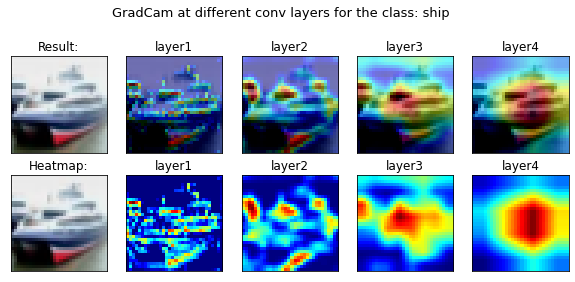

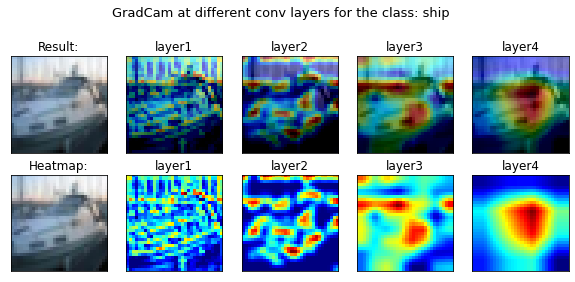

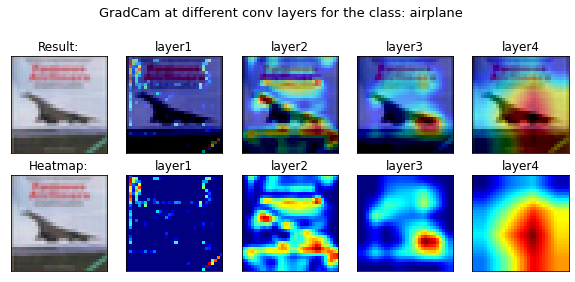

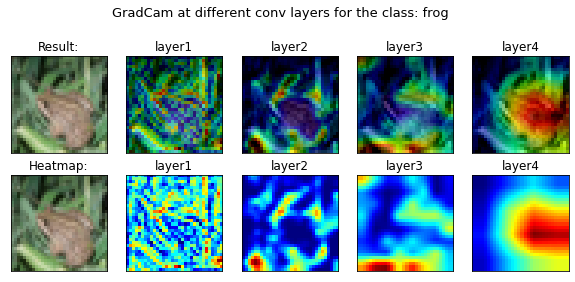

In [21]:
num_img = 5
correct_pred_imgs = []
for i in range(num_img):
  correct_pred_imgs.append(test_set[i][0])
viz_cam(torch.stack(correct_pred_imgs), target_layers, metric="Correct")